In [1]:
%run setup.py
import asteroseismology as ast

/Users/yaguang/micromamba/envs/numax/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
stars = pd.read_csv('../sample/samples_rg.csv')
vrard = pd.read_csv('../sample/vrard+16.csv')
stars = stars.merge(vrard[['KIC', 'DPi1', 'e_DPi1']], on='KIC', how='left')

# idx = stars['DPi1'].notna() & stars['e_DPi1'].notna()
# stars = stars[idx].reset_index(drop=True)

# stars = stars.loc[idx,:].reset_index(drop=True)
modes = pd.read_csv('../sample/modes_rg.csv')

ebs = pd.read_csv('../sample/samples_eb.csv')

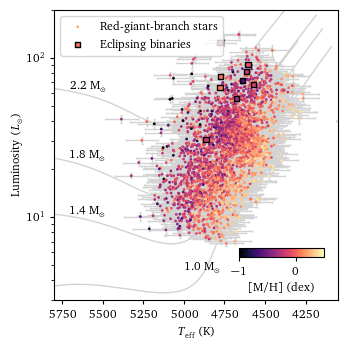

In [3]:
fig, axes = plt.subplots(figsize=figsize(ratio=1.,column='one'), nrows=1, ncols=1, 
                         squeeze=False, constrained_layout=True) #, gridspec_kw={'wspace':0.5,'hspace':0.5}
axes = axes.reshape(-1)

import matplotlib.colors
norm = matplotlib.colors.Normalize(vmin=-1.0, vmax=0.5)
cmap = 'magma'
msize, lw, mew, alpha = 4, 0.5, 0.5, 1.

# sunstyle = {'marker':'$\\odot$', 's':msize+32, 'edgecolor':'k', 'facecolor':'none', 'linewidths':0.4, 'label':'Sun', 'alpha':alpha, 'norm':norm}
rgstyle = {'marker':'.', 'cmap': cmap, 's':msize, 'label':'Red-giant-branch stars', 'alpha':alpha, 'norm':norm}
ebstyle = {'marker':'s', 'cmap': cmap, 's':msize+10, 'label':'Eclipsing binaries', 'alpha':alpha, 'norm':norm, 'edgecolor':'k'}
# sgstyle = {'marker':'^', 'cmap': cmap, 's':msize, 'label':'Subgiant', 'alpha':alpha, 'norm':norm}
errorstyles = {'linestyle':'none', 'ecolor':'lightgray', 'capsize':1, 'elinewidth':1, 'zorder':-10}


idxes = [stars.index > -1]
styles = [rgstyle]


axes[-1].scatter(stars['Teff'], stars['luminosity'], c=stars['[M/H]'], rasterized=True, **rgstyle)
axes[-1].errorbar(stars['Teff'], stars['luminosity'],
                xerr = stars['e_Teff'], yerr=stars['e_luminosity'], rasterized=True, 
                 **errorstyles)

axes[-1].scatter(ebs['Teff'], ebs['luminosity'], c=ebs['[M/H]'], rasterized=True, **ebstyle)
axes[-1].errorbar(ebs['Teff'], ebs['luminosity'],
                xerr = ebs['e_Teff'], yerr=ebs['e_luminosity'], rasterized=True, 
                 **errorstyles)

axes[-1].axis([5800, 4050, 3, 200.])
axes[-1].set_yscale('log')
axes[-1].set_xlabel('$T_{\\rm{eff}}$  (K)')
axes[-1].set_ylabel('Luminosity ($L_{\\odot}$)')
axes[-1].legend(fontsize=fontsize, loc='upper left')

# get tracks 
# params = pd.read_csv(rootpath+'hpc/coarse_v2/template/coarse_grid_input_params_v2.txt', engine='python', sep=', ')
params = pd.read_csv('../../hpc/coarse_v5/template/coarse_grid_input_params_v5.txt', engine='python', sep=', ')
Zsun, Xsun = 0.0134, 0.7381
params['feh'] = np.log10(params['Zinit']/params['Xinit']) - np.log10(Zsun/Xsun)
masses = np.array([1.0, 1.4, 1.8, 2.2])
e_mass = 0.01
Yinit, e_Yinit = 0.290, 0.01
amlt, e_amlt = 1.7, 0.02
feh, e_feh = 0., 0.01

indexes = []
for mass in masses:
    metric = (params['star_mass']-mass)**2.0/e_mass**2.0 + \
    (params['Yinit']-Yinit)**2.0/e_Yinit**2.0 + \
    (params['amlt']-amlt)**2.0/e_amlt**2.0 + \
    (params['feh']-feh)**2.0/e_feh**2.0 
    indexes.append(np.argmin(metric))

indexes = [6167, 6891, 3897, 1093]
for i in indexes:
    # data=h5py.File(rootpath+'hpc/coarse_v2/pre_rgb_tip/complete_grid/index{:06.0f}.history.h5'.format(i), 'r')
    data=h5py.File('../../hpc/coarse_v5/pre_rgb_tip/complete_grid/index{:06.0f}.history.h5'.format(i), 'r')
    idx = (data['phase'][:]>=0) & (10.0**(data['log_LHe'][:]-data['log_Lnuc'][:])<0.00001)
    axes[-1].plot(data['Teff'][idx], data['luminosity'][idx], c='lightgray', linestyle='-', lw=1, zorder=-9)

    if i == 6167:
        idx = idx & (data['Teff'][:]<4900)
        axes[-1].text(data['Teff'][idx][0]*1.02, data['luminosity'][idx][0]*1.1, '{:0.1f}'.format(data['star_mass'][idx][0])+' M$_{\\odot}$',)
    else:
        idx = idx & (data['Teff'][:]<5800)
        axes[-1].text(5700, data['luminosity'][idx][0]*1., '{:0.1f}'.format(data['star_mass'][idx][0])+' M$_{\\odot}$',)


for ax in axes:
    cax = ax.inset_axes([0.65, 0.15, 0.3, 0.03], transform=ax.transAxes)
    fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, ax=ax, orientation='horizontal').set_label('[M/H] (dex)')

filename = 'Fig.1_HRD.pdf'
plt.savefig(filename)
os.system(to_overleaf(filename, 'figures'))

In [45]:
# stars['grav'] = (stars['numax']/3090)*(stars['Teff']/5777)**0.5
# stars['e_grav'] = stars['grav'] * ((stars['e_numax']/stars['numax'])**2.0 + (0.5*stars['e_Teff']/stars['Teff'])**2.0  )**0.5
# stars['logg'] = np.log10(stars['grav']) + np.log10(27400)
# stars['e_logg'] = (1/(stars['grav'])*np.log10(np.e)) * stars['e_grav']

# ebs['grav'] = (ebs['numax']/3090)*(ebs['Teff']/5777)**0.5
# ebs['e_grav'] = ebs['grav'] * ((ebs['e_numax']/ebs['numax'])**2.0 + (0.5*ebs['e_Teff']/ebs['Teff'])**2.0  )**0.5
# ebs['logg'] = np.log10(ebs['grav']) + np.log10(27400)
# ebs['e_logg'] = (1/(ebs['grav'])*np.log10(np.e)) * ebs['e_grav']